### Домашняя работа 6

In [ ]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import sys

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import nltk
from nltk.tag import BigramTagger, TrigramTagger, UnigramTagger
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [ ]:
def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    accuracy = accuracy_score(test_df['is_positive'], preds)
    
    result = round(accuracy*100, 2)
    # print(f'Test accuracy = {result}%')
    
    return result

def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)

    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)

    return data

### Загрузка данных

In [ ]:
# Loading data
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print(f'Train size = {len(train_df)}')
print(f'Test size = {len(test_df)}')

Train size = 25000
Test size = 25000


<a list of 230 Patch objects>

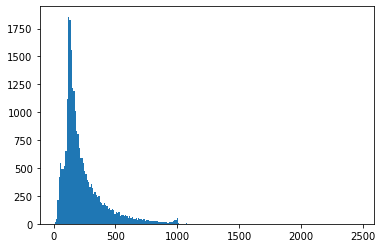

In [ ]:
hist = plt.hist(train_df['review'].apply(lambda text: len(text.split())), bins='auto')[2]
hist

In [ ]:
words_counter = Counter((word for text in train_df['review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['review'], word2idx, 1000)
X_test = convert(test_df['review'], word2idx, 1000)

Words count 27299


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.32
0,CountVectorizer,86.31
2,HashingVectorizer,85.94


In [ ]:
# RandomForestClassifier
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', RandomForestClassifier(n_estimators=825, max_depth=8, random_state=15, max_features=7))
    ])
    net.fit(train_df['review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline2 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline2.sort_values('accuracy', ascending=False)

,model,accuracy
0,CountVectorizer,78.81
1,TfidfVectorizer,76.60
2,HashingVectorizer,67.35


In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline3 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline3.sort_values('accuracy', ascending=False)

Epoch 1/10
782/782 [==============================] - 50s 63ms/step - loss: 0.6878 - accuracy: 0.5660 - val_loss: 0.6463 - val_accuracy: 0.7644
Epoch 2/10
782/782 [==============================] - 48s 61ms/step - loss: 0.6147 - accuracy: 0.7542 - val_loss: 0.5365 - val_accuracy: 0.7902
Epoch 3/10
782/782 [==============================] - 49s 63ms/step - loss: 0.5016 - accuracy: 0.8162 - val_loss: 0.4535 - val_accuracy: 0.8298
Epoch 4/10
782/782 [==============================] - 50s 64ms/step - loss: 0.4231 - accuracy: 0.8484 - val_loss: 0.4002 - val_accuracy: 0.8496
Epoch 5/10
782/782 [==============================] - 50s 63ms/step - loss: 0.3610 - accuracy: 0.8712 - val_loss: 0.3712 - val_accuracy: 0.8520
Epoch 6/10
782/782 [==============================] - 48s 61ms/step - loss: 0.3215 - accuracy: 0.8841 - val_loss: 0.3403 - val_accuracy: 0.8685
Epoch 7/10
782/782 [==============================] - 48s 61ms/step - loss: 0.2954 - accuracy: 0.8935 - val_loss: 0.3243 - val_accuracy:

,model,accuracy
0,Net,87.812001


In [ ]:
final_result = pd.concat([best_baseline, best_baseline3], axis=0)
final_result.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.320000
0,Net,87.812001
0,CountVectorizer,86.310000
2,HashingVectorizer,85.940000


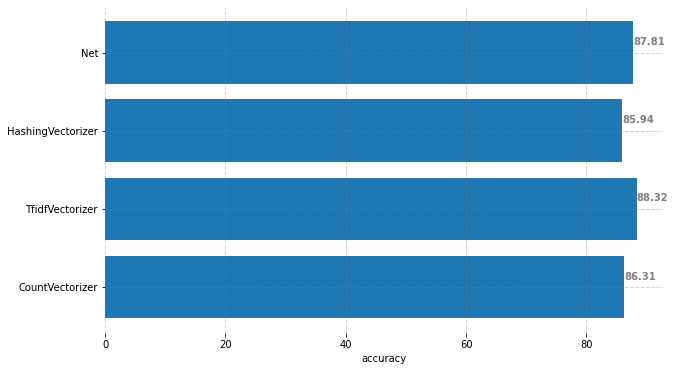

In [ ]:
x = final_result['model']
y = final_result['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

### 1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново  

In [ ]:
train_df['clean_review'] = train_df['review']
test_df['clean_review'] = test_df['review']
train_df.head()

,is_positive,review,clean_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...,My all-time favorite movie! I have seen many m...


In [ ]:
train_df.tail()

,is_positive,review,clean_review
24995,1,"I am a big fan of the movie, but not for the u...","I am a big fan of the movie, but not for the u..."
24996,0,I'm not going to bother with a plot synopsis s...,I'm not going to bother with a plot synopsis s...
24997,0,This movie . . . I don't know. Why they would ...,This movie . . . I don't know. Why they would ...
24998,1,Saw this film on DVD yesterday and was gob-sma...,Saw this film on DVD yesterday and was gob-sma...
24999,0,This was a disappointment - none of the nuance...,This was a disappointment - none of the nuance...


In [ ]:
# Заменим html-сущности
import html
html.unescape(train_df['clean_review'])

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: clean_review, Length: 25000, dtype: object

In [ ]:
# Изменим регистр на нижний с помощью .lower()
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : x.lower())
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : x.lower())

In [ ]:
# Заменим пунктуацию на пробелы, используя re.sub() и паттерн r'[^\w\s]'
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))

In [ ]:
# Заменим спец. символы на пробелы, используя re.sub() и паттерн r'[^a-zA-Z0-9]'
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z0-9]', ' ', x))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z0-9]', ' ', x))

In [ ]:
# Заменим числа на пробелы, используя re.sub() и паттерн r'[^a-zA-Z]'
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z]', ' ', x))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z]', ' ', x))

In [ ]:
# Удалим из текста слова длиной в 1 символ
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>1]))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>1]))

In [ ]:
# create custom stop words list
my_stop_words = ['DVD', 'me', 'i', 'she', 'it']
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in my_stop_words]))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in my_stop_words]))

<a list of 229 Patch objects>

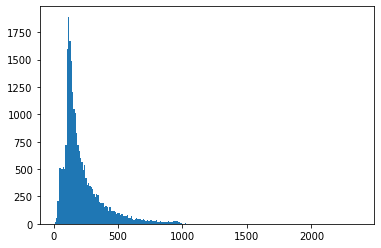

In [ ]:
hist2 = plt.hist(train_df['clean_review'].apply(lambda text: len(text.split())), bins='auto')[2]
hist2

In [ ]:
words_counter = Counter((word for text in train_df['clean_review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['clean_review'], word2idx, 1000)
X_test = convert(test_df['clean_review'], word2idx, 1000)

Words count 19847


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['clean_review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline4 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline4.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.30
0,CountVectorizer,86.30
2,HashingVectorizer,86.12


In [ ]:
# RandomForestClassifier
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', RandomForestClassifier())
    ])
    net.fit(train_df['review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline5 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline5.sort_values('accuracy', ascending=False)

,model,accuracy
0,CountVectorizer,78.81
1,TfidfVectorizer,76.60
2,HashingVectorizer,67.35


In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline6 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline6.sort_values('accuracy', ascending=False)

Epoch 1/10
782/782 [==============================] - 45s 57ms/step - loss: 0.6841 - accuracy: 0.5917 - val_loss: 0.6203 - val_accuracy: 0.7786
Epoch 2/10
782/782 [==============================] - 44s 56ms/step - loss: 0.5779 - accuracy: 0.7957 - val_loss: 0.5043 - val_accuracy: 0.7894
Epoch 3/10
782/782 [==============================] - 44s 56ms/step - loss: 0.4550 - accuracy: 0.8424 - val_loss: 0.4171 - val_accuracy: 0.8524
Epoch 4/10
782/782 [==============================] - 44s 56ms/step - loss: 0.3720 - accuracy: 0.8728 - val_loss: 0.3706 - val_accuracy: 0.8574
Epoch 5/10
782/782 [==============================] - 45s 58ms/step - loss: 0.3188 - accuracy: 0.8907 - val_loss: 0.3388 - val_accuracy: 0.8740
Epoch 6/10
782/782 [==============================] - 45s 58ms/step - loss: 0.2850 - accuracy: 0.8988 - val_loss: 0.3167 - val_accuracy: 0.8808
Epoch 7/10
782/782 [==============================] - 46s 59ms/step - loss: 0.2566 - accuracy: 0.9076 - val_loss: 0.3066 - val_accuracy:

,model,accuracy
0,Net,88.888001


In [ ]:
final_result2 = pd.concat([best_baseline4, best_baseline6], axis=0)
final_result2.sort_values('accuracy', ascending=False)

,model,accuracy
0,Net,88.888001
1,TfidfVectorizer,88.300000
0,CountVectorizer,86.300000
2,HashingVectorizer,86.120000


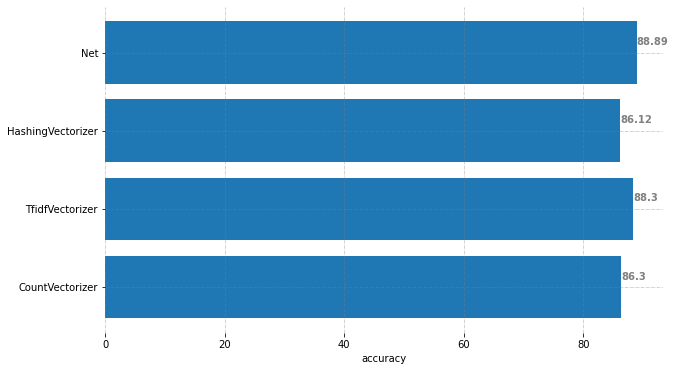

In [ ]:
x = final_result2['model']
y = final_result2['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

In [ ]:
final_results = pd.concat([final_result, final_result2], axis=1, 
                         keys=['baseline', 'pre-processing'])

In [ ]:
final_results

baseline                pre-processing           
               model   accuracy              model   accuracy
0    CountVectorizer  86.310000    CountVectorizer  86.300000
1    TfidfVectorizer  88.320000    TfidfVectorizer  88.300000
2  HashingVectorizer  85.940000  HashingVectorizer  86.120000
0                Net  87.812001                Net  88.888001

### 2. Проверьте повысилось ли качество на стандартных подходах при лемматизации

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_df['lemmatized_review'] = train_df['review'].apply(lambda x : word_tokenize(x))
test_df['lemmatized_review'] = test_df['review'].apply(lambda x : word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lemmatizer = WordNetLemmatizer()
train_df['lemmatized_review'] = train_df['lemmatized_review'].apply(lambda x : [lemmatizer.lemmatize(word, wordnet.VERB) for word in x])
test_df['lemmatized_review'] = test_df['lemmatized_review'].apply(lambda x : [lemmatizer.lemmatize(word, wordnet.VERB) for word in x])

In [ ]:
train_df['lemmatized_review'] = np.array([' '.join(x) for x in train_df['lemmatized_review']])
test_df['lemmatized_review'] = np.array([' '.join(x) for x in test_df['lemmatized_review']])

In [ ]:
train_df['lemmatized_review']

0        Dreamgirls , despite its fistful of Tony win i...
1        This show come up with interest locations as f...
2        I simply love this movie . I also love the Ram...
3        Spoilers ahead if you want to call them that ....
4        My all-time favorite movie ! I have see many m...
                               ...                        
24995    I be a big fan of the movie , but not for the ...
24996    I 'm not go to bother with a plot synopsis sin...
24997    This movie . . . I do n't know . Why they woul...
24998    Saw this film on DVD yesterday and be gob-smac...
24999    This be a disappointment - none of the nuance ...
Name: lemmatized_review, Length: 25000, dtype: object

In [ ]:
words_counter = Counter((word for text in train_df['lemmatized_review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['lemmatized_review'], word2idx, 1000)
X_test = convert(test_df['lemmatized_review'], word2idx, 1000)

Words count 18187


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['lemmatized_review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline7 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline7.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,87.08
0,CountVectorizer,83.35
2,HashingVectorizer,83.27


In [ ]:
# RandomForestClassifier
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', RandomForestClassifier())
    ])
    net.fit(train_df['lemmatized_review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline8 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline8.sort_values('accuracy', ascending=False)

In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline9 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline9.sort_values('accuracy', ascending=False)

In [ ]:
final_result3 = pd.concat([best_baseline7, best_baseline9], axis=0)
final_result3.sort_values('accuracy', ascending=False)

In [ ]:
x = final_result3['model']
y = final_result3['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

In [ ]:
final_results = pd.concat([final_result, final_result2, final_result3], axis=1, 
                         keys=['baseline', 'pre-processing', 'lemmatize'])

In [ ]:
final_results

### 3. Удалите из текстов какие-то из сущностей(не удалите а замените их тегом). Запустите классификатор.

In [ ]:
for idx, text in enumerate(train_df['review']): # перебираем каждый текст в датасете
    chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    names = {' '.join(c[0] for c in chunk) for chunk in chunks if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
    names = sorted(names, key=len, reverse=True)
    for name in names:
        train_df.loc[idx, 'review'] = re.sub(name, 'PERSON', text)

In [ ]:
for idx, text in enumerate(test_df['review']): # перебираем каждый текст в датасете
    chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    names = {' '.join(c[0] for c in chunk) for chunk in chunks if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
    names = sorted(names, key=len, reverse=True)
    for name in names:
        try:
            test_df.loc[idx, 'review'] = re.sub(name, 'PERSON', text)
        except:
            pass

In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline10 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline10.sort_values('accuracy', ascending=False)

In [ ]:
# RandomForestClassifier
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', RandomForestClassifier())
    ])
    net.fit(train_df['review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline11 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline11.sort_values('accuracy', ascending=False)

In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline12 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline12.sort_values('accuracy', ascending=False)

In [ ]:
final_result4 = pd.concat([best_baseline10, best_baseline12], axis=0)
final_result4.sort_values('accuracy', ascending=False)

In [ ]:
final_results = pd.concat([final_result, final_result2, final_result3, final_result4], axis=1, 
                         keys=['baseline', 'pre-processing', 'lemmatize', 'tag'])

In [ ]:
final_results

### 4. Поэкспериментируйте с подходом с сеточками на разных данных (с удалёнными сущностями или без)